In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('wind_data.csv')

In [3]:
df.head(5)


,case_id,eia_id,t_state,t_county,t_fips,p_name,p_year,p_tnum,p_cap,t_manu,...,t_rsa,t_ttlh,retrofit,retrofit_year,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat
0,3072661,52161.0,CA,Kern County,6029,251 Wind,1987.0,194,18.43,Vestas,...,NaN,NaN,0,NaN,2,3,8/5/2018,Digital Globe,-118.363762,35.077908
1,3072695,52161.0,CA,Kern County,6029,251 Wind,1987.0,194,18.43,Vestas,...,NaN,NaN,0,NaN,2,3,8/5/2018,Digital Globe,-118.364410,35.077435
2,3072704,52161.0,CA,Kern County,6029,251 Wind,1987.0,194,18.43,Vestas,...,NaN,NaN,0,NaN,2,3,8/5/2018,Digital Globe,-118.364197,35.077644
3,3063272,NaN,IA,Story County,19169,30 MW Iowa DG Portfolio,2017.0,10,30.00,Nordex,...,12271.85,150.0,0,NaN,3,3,24/4/2017,Digital Globe,-93.430367,42.028233
4,3053390,NaN,IA,Boone County,19015,30 MW Iowa DG Portfolio,2017.0,10,30.00,Nordex,...,12271.85,150.0,0,NaN,3,3,1/6/2017,Digital Globe,-93.700424,41.977608


In [4]:
df.dtypes

case_id            int64
eia_id           float64
t_state           object
t_county          object
t_fips             int64
p_name            object
p_year           float64
p_tnum             int64
p_cap            float64
t_manu            object
t_model           object
t_cap            float64
t_hh             float64
t_rd             float64
t_rsa            float64
t_ttlh           float64
retrofit           int64
retrofit_year    float64
t_conf_atr         int64
t_conf_loc         int64
t_img_date        object
t_img_srce        object
xlong            float64
ylat             float64
dtype: object

In [5]:
# set p_year to datetime

df['p_year'] = pd.to_datetime(df['p_year'], format='%Y')

In [7]:
# set p_year to index

df = df.set_index('p_year')

In [7]:
# aggregate by year
cap_df = df.groupby('p_year')['t_cap'].agg(['sum'])

# rename 'sum' to 'total_cap
cap_df = cap_df.rename(columns={'sum': 'yearly_cap'})

# rename index to 'year'
cap_df = cap_df.rename_axis('Date')

cap_df.head()

,yearly_cap
Date,
1982-01-01,323.0
1983-01-01,28080.0
1984-01-01,10070.0
1985-01-01,25025.0
1986-01-01,8600.0


In [9]:
# create new column with cumulative total of capactiy

cap_df['cumulative_total'] = cap_df.cumsum()

In [10]:
cap_df.tail()

,yearly_cap,cumulative_total
Date,,
2017-01-01,7009520.0,86926501.0
2018-01-01,7408935.0,94335436.0
2019-01-01,9091115.0,103426551.0
2020-01-01,17286530.0,120713081.0
2021-01-01,6457030.0,127170111.0


In [11]:
# drop 'yearly cap' column

cap_df.drop('yearly_cap', axis=1, inplace = True)

In [16]:
# set frequency of index to yearly

cap_df.index = pd.date_range(start = cap_df.index.min(), end = cap_df.index.max(), freq='Y')

cap_df.tail()

,cumulative_total
2016-12-31,86926501.0
2017-12-31,94335436.0
2018-12-31,103426551.0
2019-12-31,120713081.0
2020-12-31,127170111.0


In [48]:
# create train test split

train = cap_df['1982-12-31':'2014-12-31']
test = cap_df['2015-12-31':'2020-12-31']

test

,cumulative_total
2015-12-31,79916981.0
2016-12-31,86926501.0
2017-12-31,94335436.0
2018-12-31,103426551.0
2019-12-31,120713081.0
2020-12-31,127170111.0


In [52]:
train.tail()

,cumulative_total
2010-12-31,44412693.0
2011-12-31,57361913.0
2012-12-31,58450738.0
2013-12-31,63233476.0
2014-12-31,71808134.0


In [26]:
from statsmodels.tsa.arima.model import ARIMA

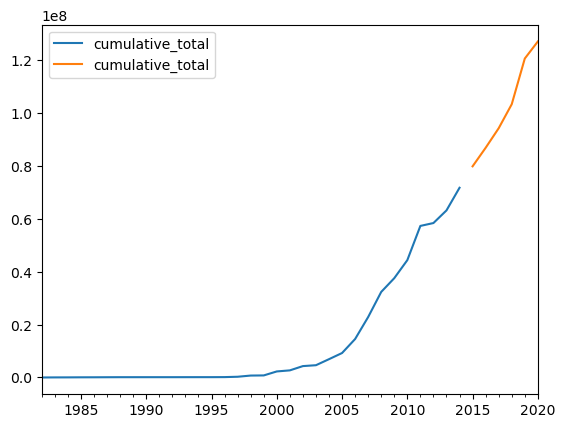

In [53]:
# plot train test split

fig, ax = plt.subplots()

train.plot(ax = ax, label = 'train')
test.plot(ax = ax, label = 'test')

ax.legend()

In [68]:
model = ARIMA(train, order = (1, 3, 7)).fit()

y_pred = model.predict(start = '2015-12-31', end = '2020-12-31')

<function matplotlib.pyplot.show(close=None, block=None)>

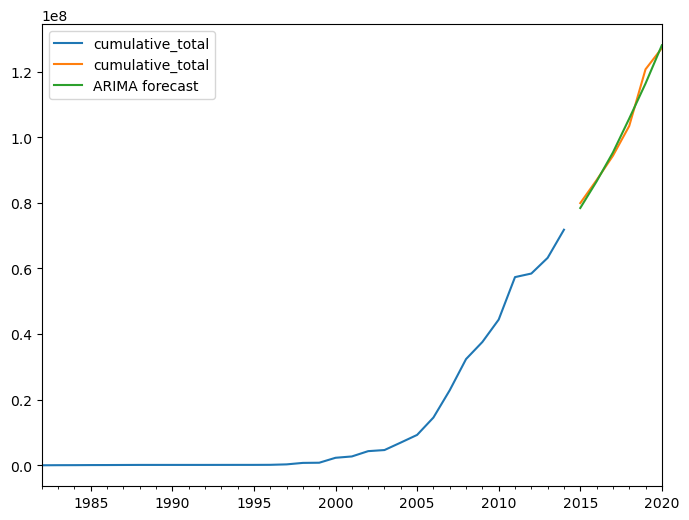

In [69]:
fig, ax = plt.subplots(figsize = (8, 6))
                       
train.plot(ax = ax, label = 'train')
test.plot(ax = ax, label = 'test')
y_pred.plot(ax = ax, label = 'ARIMA forecast')
ax.legend()

plt.show

In [56]:
import numpy as np
import warnings

from sklearn.metrics import mean_squared_error

print(f'ARIMA(1,0,1) RMSE: {np.sqrt(mean_squared_error(test, y_pred))}')

ARIMA(1,0,1) RMSE: 35432809.44237062


In [65]:
rmse_max = 10000000000

# Ignore warnings
warnings.filterwarnings("ignore")

best_value = []
for p in range(10):
    for d in range(5):
        for q in range(10):
            try:
                model = ARIMA(train, order=(p, d, q)).fit()
                y_pred = model.predict(start = '2015-12-31', end = '2020-12-31')
                rmse = np.sqrt(mean_squared_error(test, y_pred))
                if rmse < rmse_max:
                    rmse_max = rmse
                    best_value = [rmse, p, d, q]
            except:
                pass

best_value

[2162963.1190708876, 1, 3, 7]

In [62]:
pred_model = ARIMA(cap_df, order = (1, 3, 7)).fit()

y_pred_future = pred_model.predict(start = '2021-12-31', end = '2025-12-31')

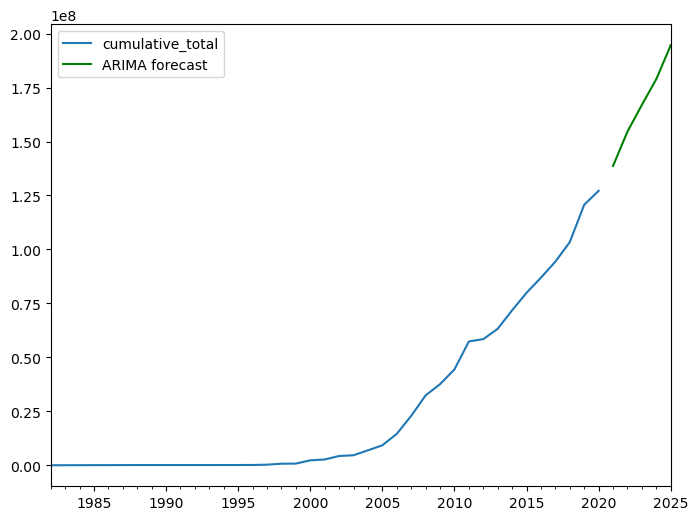

In [63]:
fig, ax = plt.subplots(figsize = (8, 6))
                       
cap_df.plot(ax = ax)
y_pred_future.plot(ax = ax, label = 'ARIMA forecast', color = 'green')
ax.legend()

plt.show;

In [64]:
y_pred_future

2021-12-31    1.387043e+08
2022-12-31    1.546109e+08
2023-12-31    1.669820e+08
2024-12-31    1.789343e+08
2025-12-31    1.946043e+08
Freq: A-DEC, Name: predicted_mean, dtype: float64